In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset

import alphalens 
from alphalens.utils import print_table

import json
from tqdm import *
from jqdata import *
import tushare as ts

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体


# 数据获取

## 构造数据获取函数

In [2]:
# 获取基金基础信息
def GetFundInfo(start_date:str,end_date:str)->pd.DataFrame:
    
    # 按年度获取
    start_period = pd.date_range(start_date,end_date,freq='YS')
    end_period = pd.date_range(start_date,end_date,freq='Y')

    df_list = []
    
    for start,end in zip(start_period,end_period):
        
        df_list.append(Query_Fund_Info(start,end))
    
    return pd.concat(df_list)

# jq数据基金分类之区分股票和混合 没有更细的分类
def Query_Fund_Info(start_date: str, end_date: str) -> pd.DataFrame:
    '''获取某时间段中开放式基金中的股票型、混合型基金数据'''

    q = query(finance.FUND_MAIN_INFO).filter(finance.FUND_MAIN_INFO.operate_mode == '开放式基金',
                                             finance.FUND_MAIN_INFO.underlying_asset_type.in_(
                                                 ['股票型', '混合型']),
                                             finance.FUND_MAIN_INFO.start_date >= start_date,
                                             finance.FUND_MAIN_INFO.start_date <= end_date)

    return finance.run_query(q)

# 获取基金规模数据
def GetFundTotalAsset(ts_code:list,start_date:str,end_date:str)->pd.DataFrame:
    
    limit_codes = 3000  # 不能大于3000行
    
    if len(ts_code) <= limit_codes:
    
        df = Query_fund_total_asset(ts_code, start_date,end_date)
        
    else:

        code_list = [ts_code[i:i + limit_codes]
                     for i in range(0, len(ts_code), limit_codes)]

        df_temp = []

        for code in tqdm(code_list,desc='查询基金规模'):

            df_temp.append(Query_fund_total_asset(code, start_date,end_date))

        df = pd.concat(df_temp)
      
    return df


def Query_fund_total_asset(codes: list, start_date: str,end_date:str) -> pd.DataFrame:
    
    # 按季度获取
    periods = pd.date_range(start_date,end_date,freq='Q')

    df_list = []
    
    for rptdate in periods:
        
        q = query(finance.FUND_PORTFOLIO.code,
              finance.FUND_PORTFOLIO.period_end,
              finance.FUND_PORTFOLIO.pub_date,
              finance.FUND_PORTFOLIO.report_type,
              finance.FUND_PORTFOLIO.total_asset).filter(
                  finance.FUND_PORTFOLIO.code.in_(codes),
                  finance.FUND_PORTFOLIO.period_end == rptdate)
        
        df_list.append(finance.run_query(q))
    
    df = pd.concat(df_list).reset_index(drop=True)
    
    return df


# 批量查询
def GetFundsNav(main_code_list:str,start_date:str,end_date:str):
    
    # 按季度将所有数据拼接在一起
    # 每季度的交易日按60日算 限制为3000行 那么main_code需要分为每组50个
    # 才能保证最获取到所有数据
    
    temp_list = []
    
    N = 50
    
    codes = [main_code[i:i+N] for i in range(0,len(main_code),N)]
    
    for code in tqdm(codes,desc='查询基金净值'):
        
        temp_list.append(Query_Fund_Nav(code,start_date,end_date))
        
    fund_df = pd.concat(temp_list,ignore_index=True)
    
    return fund_df
        

# 查询基金累计复权净值
def Query_Fund_Nav(main_code:list,start_date:str,end_date:str)->pd.DataFrame:
    
    
    start_period = pd.date_range(start_date,end_date,freq='QS')
    end_period = pd.date_range(start_date,end_date,freq='Q')
    
    df_list = []
    for start,end in zip(start_period,end_period):
        q = query(finance.FUND_NET_VALUE.code,finance.FUND_NET_VALUE.day,
                  finance.FUND_NET_VALUE.refactor_net_value).filter(
            finance.FUND_NET_VALUE.code.in_(main_code),finance.FUND_NET_VALUE.day>=start,
            finance.FUND_NET_VALUE.day<=end)
        
        df_list.append(finance.run_query(q))
        
    return pd.concat(df_list,ignore_index=True)


## 数据获取

由于JQData公募基金分类仅区分大类品种,按照如下进行筛选可能更好:

>Wind基金类型分类选择普通股票型基金以及偏股混合型基金

所以在这里我们仅筛选出*股票型*和*混合型*基金进行分析

In [3]:
# 设置时间范围
start_date,end_date = '2007-01-01','2020-03-31'

In [4]:
# 获取基金基础数据
fund_info = GetFundInfo(start_date,end_date)

main_code = fund_info['main_code'].unique().tolist()

print('共计%s支基金'%len(main_code))

共计4248支基金


In [5]:
# 获取基金规模数据(季度)
fund_share = GetFundTotalAsset(main_code,start_date,end_date)

fund_share.to_csv('../Data/fund_share.csv')

fund_share.head()

查询基金规模: 100%|██████████| 2/2 [00:17<00:00, 10.14s/it]


,code,period_end,pub_date,report_type,total_asset
0,020018,2007-03-31,2007-04-18,第一季度,1.644130e+09
1,213003,2007-03-31,2007-04-21,第一季度,1.047415e+10
2,257030,2007-03-31,2007-04-20,第一季度,4.622084e+09
3,519017,2007-03-31,2007-04-20,第一季度,1.267888e+10
4,020018,2007-06-30,2007-07-19,第二季度,1.935767e+09


In [5]:
# 获取基金
found_nav = GetFundsNav(main_code,start_date,end_date)

found_nav.to_csv('../Data/fund_nav.csv')

found_nav.head()

查询基金净值: 100%|██████████| 85/85 [03:19<00:00,  1.54s/it]


,code,day,refactor_net_value
0,213003,2007-01-19,1.0000
1,213003,2007-01-26,1.0015
2,213003,2007-01-29,1.0061
3,213003,2007-01-30,1.0044
4,213003,2007-01-31,0.9937


# 优选基金

## 基金规模初选

**基金规模是评价基金产品的重要维度之一。我们基金选择的第一步，就是根据基金规模进行初选**。我们按照基金当期规模排序分十组，考察各组在下季度的收益情况（使用最新一期规模）。分组超额（以等权持有当季的所以基金的收益为基准）收益结果显示，**基金收益表现会受到基金规模的影响， 但二者并非线性关系，而是呈现右偏的倒U形。规模最大的基金明显跑输其他基金，平均一个季度贡献-1.25%的负向超额收益。中等规模基金表现最好。**

In [6]:
# 数据读取
fund_share = pd.read_csv('../Data/fund_share.csv', index_col=0,
                         dtype={'code': str}, parse_dates=['period_end'])
                         
fund_nav = pd.read_csv('../Data/fund_nav.csv', index_col=0,
                       dtype={'code': str}, parse_dates=['day'])

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
# step 0:

def quick_prepossessing(fund_nav: pd.DataFrame, fund_share: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    
    '''数据对齐'''
    
    fund_nav = fund_nav.copy()

    # 计算季度收益 Ser level0-day level1-code
    q_ret = fund_nav.groupby([pd.Grouper(key='day', freq='Q'), 'code'])[
        'refactor_net_value'].apply(Cala_Ret)
    q_next_ret = q_ret.groupby(level='code').transform(lambda x: x.shift(-1))
    q_next_ret.name = 'NEXT_RET'

    # 计算近一年夏普
    q_sharpe = GetSharpe(fund_nav, start_date, end_date)

    # 规模数据
    q_share = fund_share.groupby([pd.Grouper(key='period_end', freq='Q'), 'code'])[
        'total_asset'].last()

    df = pd.concat([q_next_ret, q_sharpe, q_share], axis=1, join='inner')  # 合并
    df.dropna(inplace=True)
    df.index.names = ['date', 'code']
    df.rename(columns={"total_asset": 'total_asset'.upper()}, inplace=True)

    return df.reset_index()

# step 1:
def GetSharpe(fund_nav: pd.DataFrame, start_date: str, end_date: str) -> pd.Series:
    
    '''计算每季度末近一年的夏普'''
    
    periods = pd.date_range(start_date, end_date, freq='Q')

    pivot_nav = pd.pivot_table(
        fund_nav, index='day', columns='code', values='refactor_net_value')
    idx = pivot_nav.index

    rpt_trade_dic = idx.to_frame().resample('Q').last()
    rpt_trade_dic = rpt_trade_dic['day'].to_dict()

    df = pd.DataFrame(index=periods, columns=pivot_nav.columns)

    for i in periods:

        end = idx.get_loc(rpt_trade_dic[i])
        start = end - 244

        if start < 0:

            df.loc[i, :] = np.nan

        else:

            df.loc[i, :] = Cala_Sharpe(pivot_nav.iloc[start:end, :])

    ser = df.stack()
    ser = ser.astype(float)
    ser.name = 'sharpe'.upper()

    return ser

# step 2:
def Cala_Sharpe(nav: pd.DataFrame) -> pd.Series:
    
    '''计算夏普'''
    
    per_nav = nav.shift(1)
    ret = np.log1p(nav.pct_change())

    cum = np.exp(ret.cumsum()) - 1
    annual_ret = (1 + cum) ** (252 / len(cum)) - 1
    annual_ret = annual_ret.iloc[-1]  # 年化收益率

    volatility = ret.std() * np.sqrt(252) # 年化波动率

    return ((annual_ret - 0.04) / volatility).replace([- np.inf, np.inf], np.nan)

# step 3:
def Cala_Ret(nav: pd.Series) -> float:
    
    '''计算累计收益'''
    
    return np.sum(np.log(nav / nav.shift(1))) # 累计收益率


In [8]:
# 初始化数据
df = quick_prepossessing(fund_nav,fund_share,start_date,end_date)

df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log1p


,date,code,NEXT_RET,SHARPE,TOTAL_ASSET
0,2008-03-31,000031,-0.094815,-0.700139,4.311237e+09
1,2008-03-31,020010,-0.170527,0.110247,5.063917e+09
2,2008-03-31,020011,-0.221723,0.091869,4.825745e+09
3,2008-03-31,040007,-0.239293,2.313625,1.669839e+10
4,2008-03-31,040008,-0.175549,0.999229,1.714130e+10


In [9]:
def Get_Grop(df:pd.DataFrame,col:str):
    
    '''分组函数'''
    
    df_ = df.copy()
    
    label_name = [str(i) for i in range(1,11)]
    df_['GROUP'] = pd.qcut(df_[col],10,labels=label_name)
    
    # 基准收益假设为等权持有当季度的所有基金的收益
    #df.rename(columns={'refactor_net_value':'NEXT_RET'})
    df_['EXCESS_RET'] = df_['NEXT_RET'] - df_['NEXT_RET'].mean()
    
    return df_

In [10]:
# 按规模分组
group_df = Get_Grop(df,'TOTAL_ASSET')

group_df.head()

,date,code,NEXT_RET,SHARPE,TOTAL_ASSET,GROUP,EXCESS_RET
0,2008-03-31,000031,-0.094815,-0.700139,4.311237e+09,10,-0.107831
1,2008-03-31,020010,-0.170527,0.110247,5.063917e+09,10,-0.183544
2,2008-03-31,020011,-0.221723,0.091869,4.825745e+09,10,-0.234740
3,2008-03-31,040007,-0.239293,2.313625,1.669839e+10,10,-0.252310
4,2008-03-31,040008,-0.175549,0.999229,1.714130e+10,10,-0.188566


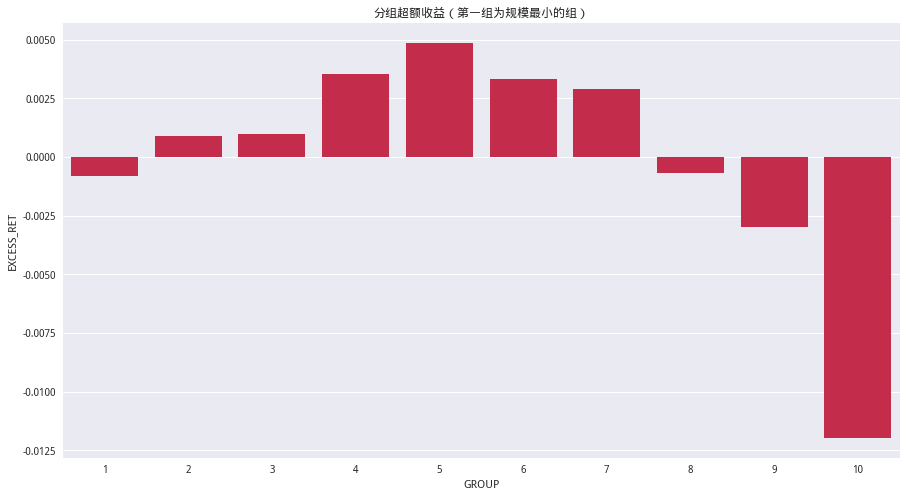

In [11]:
plt.rcParams['font.family']='serif'
plt.figure(figsize=(15,8))
plt.title('分组超额收益（第一组为规模最小的组）')
sns.barplot(x='GROUP',y='EXCESS_RET',data=group_df,ci=0,color='#DC143C')

一般来说，基金产品规模越大，意味投资者对基金经理能力的认可度越高，基金经理实力越强。 同时基金获取数据和研究服务的成本，以及管理成本和间接费用并不会随规模的增长同比例增加， 这些会给基金带来正的规模经济效应。然而实证结果显示，大规模基金未来业绩表现反而不佳。可能的原因有以下几点：**（1）流动性约束与价格冲击**：大规模交易使得基金调仓灵活性变差，可能 会错过买卖股票的最佳时机，而小基金“船小好调头”。此外大额交易带来的冲击成本也会提高。 **（2）基金经理管理能力限制**：基金投资受限于“双十规定”（一只基金持同一股票不得超过基金 资产的 10%，一个基金公司旗下所有基金持同一股票不得超过该股票市值的 10%。），被迫分散投资，很难集中仓位于少数几只精选股票，导致类指数化投资的尴尬。此外，规模做大后，维持业绩稳定是基金经理的首要目标，追求短期高收益的动力不足。**（3）打新收益稀释**：基金参与打新 可以增厚收益，而打到手的新股是有上限的，大规模基金的打新收益会被稀释。此外，**小规模基金 虽然也能带来一定超额收益，但流动性较差，资质良莠不齐，更易受到日常申赎的影响，业绩波动 可能较大。**

综合考虑后，此处我们**选择规模大于 10 亿且小于 100 亿的中等规模基金作为研究对象**。每季度基金规模的剔除比例如下图所示。可以看到，2008 年之后，由于基金供给有限，供不应求使得基金规模迅速膨胀。

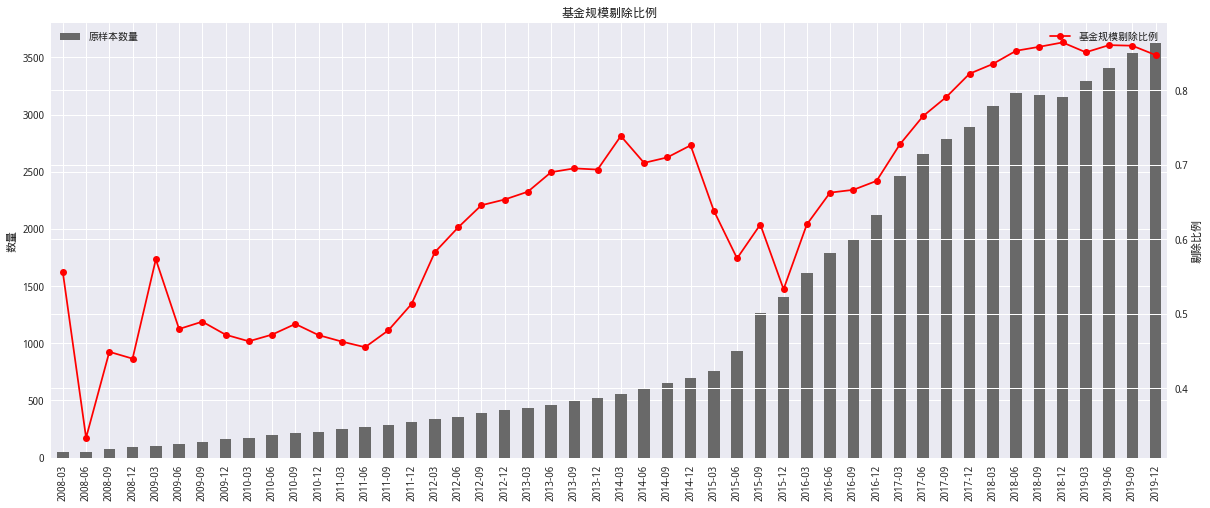

In [12]:
# 总个数
total_fund = df['date'].dt.strftime('%Y-%m').value_counts().sort_index()

# 研究对象
target_fund = df.query('TOTAL_ASSET > 10e8 and TOTAL_ASSET < 100e8')['date'].dt.strftime('%Y-%m').value_counts().sort_index()

# 剔除比例
percent = (1 - target_fund / total_fund)

total_fund.plot.bar(figsize=(20,8),color='DimGray',title='基金规模剔除比例')
plt.legend(['原样本数量'],loc='upper left')
plt.ylabel('数量')
plt.twinx()
percent.plot(marker='o',color='r')
plt.legend(['基金规模剔除比例'],loc='upper right')
plt.ylabel('剔除比例')
plt.show()

## 选基指标

我们使用**夏普比率作为选基指标**。夏普比率，是一个可以同时对收益与风险加以综合考虑的指标，广泛运用于基金市场，目前已成为国际上用以衡量基金绩效表现的最为常用的一个 标准化指标。夏普比率的核心思想就是，在固定的所能承受的风险时，追求最大报酬；在固定的预 期报酬下，追求最低的风险。下面我们在进行过规模筛选后的基金池中，**每季度末按照过去一年的夏普比率将基金分十组**，考察 top10%基金构成的等权基金组合相对于基金池的超额收益。可以看 到，季度调仓的高夏普比率基金组合自2008年以来，相对于等权基金池，平均可以取得 4%的年化超额收益，最近三年更是可以取得平均 6%的年化超额收益。

In [13]:
def View_SP(df:pd.DataFrame)->pd.DataFrame:
    
    '''选取夏普最高的TOP10 查看每年收益情况'''
    
    df_ = df.copy()
    df_['date'] = pd.to_datetime(df_['date'])
    
    label_name = [str(i) for i in range(1,11)]
    df_['GROUP'] = df_.groupby('date')['SHARPE'].transform(lambda x:pd.qcut(x,10,labels=label_name))
    
    df_['EXCESS_RET'] = df_.groupby('date')['NEXT_RET'].transform(lambda x:x - x.mean())
    df_ = df_.query('GROUP == "10"')
    excess_ret = df_.groupby(pd.Grouper(key='date',freq='Y'))['EXCESS_RET'].mean()
    ret = df_.groupby(pd.Grouper(key='date',freq='Y'))['NEXT_RET'].mean()
    
    df = pd.concat([ret,excess_ret],axis=1)
    df.columns = ['RET','EXCESS_RET']
    
    return df

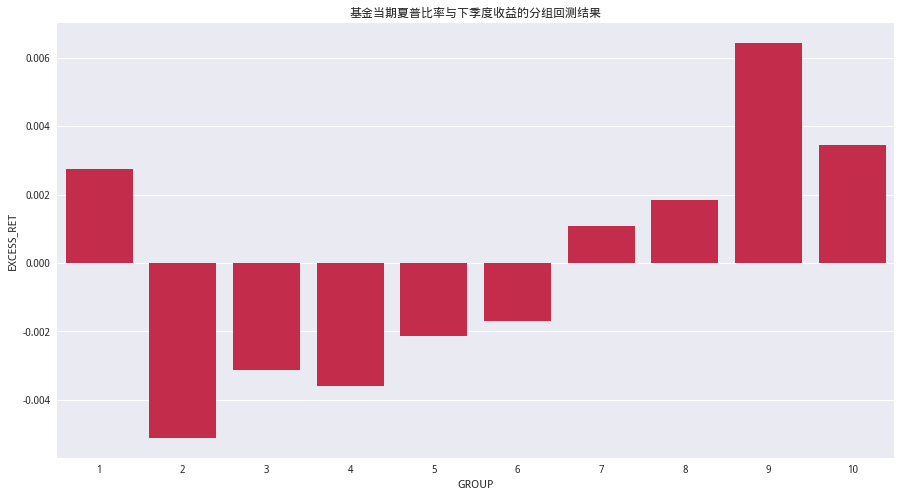

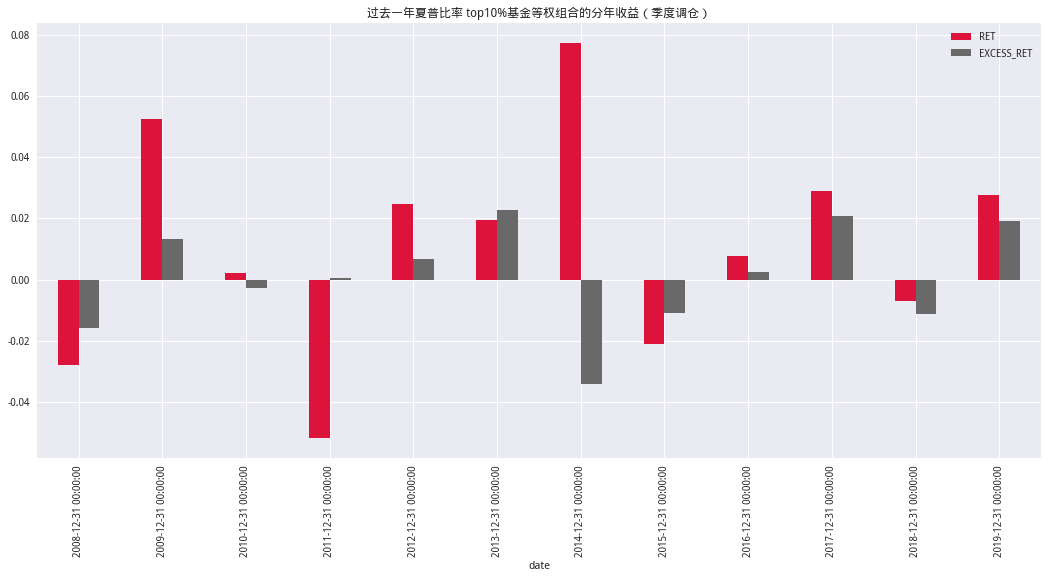

In [14]:
# 筛选 基金规模
target_fund = df.query('TOTAL_ASSET > 10e8 and TOTAL_ASSET < 100e8').copy()

x_df = target_fund.groupby('date',group_keys=False).apply(Get_Grop,col='SHARPE')

plt.figure(figsize=(15,8))
plt.title('基金当期夏普比率与下季度收益的分组回测结果')
sns.barplot(x='GROUP',y='EXCESS_RET',data=x_df,ci=0,color='#DC143C')

x_df = View_SP(target_fund)
x_df.plot.bar(figsize=(18,8),
              title='过去一年夏普比率 top10%基金等权组合的分年收益（季度调仓）'
              ,color={'#DC143C','#696969'})

## 优选基金情况

下图展示了我们每季度的优选基金的数量和平均规模。最近三年优选基金数量基本在 20 只30 只之间，平均规模基本在 20 亿-30 亿之间。

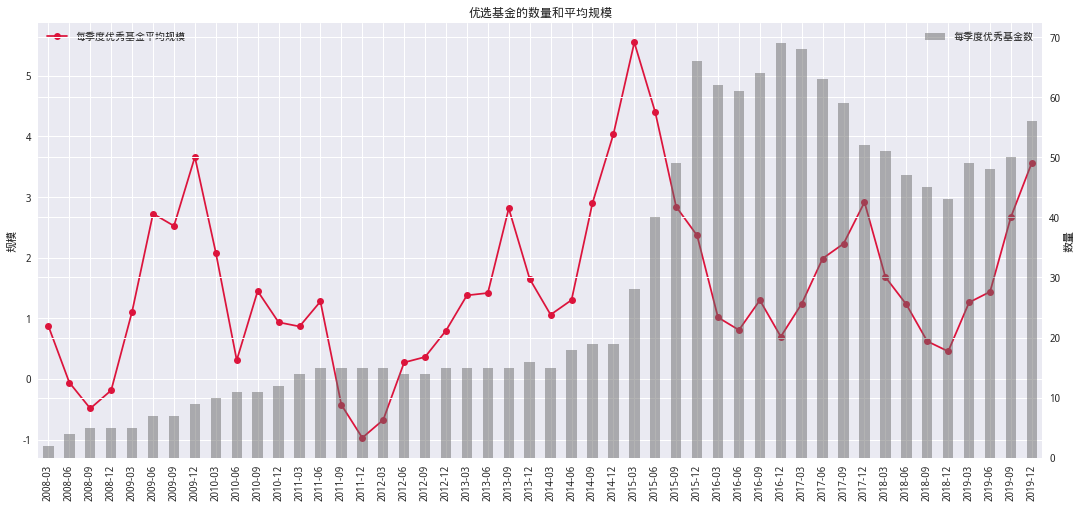

In [15]:
label_name = [str(i) for i in range(1, 11)]

target_fund['GROUP'] = target_fund.groupby('date')['SHARPE'].transform(
    lambda x: pd.qcut(x, 10, labels=label_name))

ys_fund = target_fund.query('GROUP == "10"')

x_df = pd.concat([ys_fund.groupby('date')['SHARPE'].mean(),
                  ys_fund['date'].value_counts()], axis=1)

x_df.index = pd.Index(map(lambda x: x.strftime('%Y-%m'), x_df.index))

x_df['SHARPE'].plot(figsize=(18, 8),
                    title='优选基金的数量和平均规模',
                    marker='o',
                    color='#DC143C')
                    
plt.xticks(rotation=90)
plt.ylabel('规模')
plt.legend(['每季度优秀基金平均规模'],loc='upper left')
plt.twinx()
x_df['date'].plot.bar(alpha=0.5, color='#696969')
plt.ylabel('数量')
plt.legend(['每季度优秀基金数'],loc='upper right')
plt.show()

# 挑选优选基金的超配股


## 优选基金的前十大重仓股

所谓基金重仓股，是指该股票占基金净值较大比重，对基金净值具有较大影响。一般所指的基金重仓股，是单个基金在季报中披露的权重排名前十的股票。按照基金的报告披露规则，基金管理人应当在每个季度结束之日起十五个工作日内，编制完成基金季度报告，并公布其前十大重仓股， 这些信息具有相当的及时性。下面我们根据基金季报信息，统计优选基金的前十大重仓股。如果某 股票由多只基金持仓，则计算其平均权重。 

**从优选基金组合的前十大重仓股的数量变化来看，最近三年重仓股数量明显降低，在200只左右，说明优选基金的抱团紧密度提高，心仪股票更加集中。从平均权重变化来看，重仓股平均持仓权重提高，当前在6%左右，说明单个基金的持仓分散程度降低。**

In [16]:
def GetHoldStocks(ys_fund:pd.DataFrame):
    
    df_list = []
    
    for rptdate,codes in tqdm(ys_fund.groupby('date')['code'],desc='查询持仓'):
        
        rptdate = rptdate.strftime('%Y-%m-%d')
        
        codes = codes.values.tolist()
        
        df_list.append(QueryHoldStocks(codes,rptdate))
    
    df = pd.concat(df_list,ignore_index=True)
        
    return df

def QueryHoldStocks(codes: list, rptdate: str) -> pd.DataFrame:
    
    '''查询基金重仓股'''
    
    limit = 300
    
    if len(codes) <= limit:
        
        # 获取前十持仓
        q = query(finance.FUND_PORTFOLIO_STOCK.code,
                  finance.FUND_PORTFOLIO_STOCK.period_end,
                  finance.FUND_PORTFOLIO_STOCK.pub_date,
                  finance.FUND_PORTFOLIO_STOCK.symbol,
                  finance.FUND_PORTFOLIO_STOCK.rank,
                  finance.FUND_PORTFOLIO_STOCK.proportion,
                  finance.FUND_PORTFOLIO_STOCK.report_type,
                  finance.FUND_PORTFOLIO_STOCK.market_cap).filter(
                      finance.FUND_PORTFOLIO_STOCK.code.in_(codes),
                      finance.FUND_PORTFOLIO_STOCK.rank <= 10,
                      finance.FUND_PORTFOLIO_STOCK.report_type.like('第%'),
                      finance.FUND_PORTFOLIO_STOCK.period_end == rptdate)

        df = finance.run_query(q)
        
    else:
        
        codes = [codes[i:i+limit] for i in range(0,len(codes),limit)]
        
        df_list = []
        
        for code in codes:
            
            # 获取前十持仓
            q = query(finance.FUND_PORTFOLIO_STOCK.code,
                      finance.FUND_PORTFOLIO_STOCK.period_end,
                      finance.FUND_PORTFOLIO_STOCK.pub_date,
                      finance.FUND_PORTFOLIO_STOCK.symbol,
                      finance.FUND_PORTFOLIO_STOCK.rank,
                      finance.FUND_PORTFOLIO_STOCK.report_type,
                      finance.FUND_PORTFOLIO_STOCK.proportion,
                      finance.FUND_PORTFOLIO_STOCK.market_cap).filter(
                          finance.FUND_PORTFOLIO_STOCK.code.in_(codes),
                          finance.FUND_PORTFOLIO_STOCK.rank <= 10,
                          finance.FUND_PORTFOLIO_STOCK.report_type.like('第%'),
                          finance.FUND_PORTFOLIO_STOCK.period_end == rptdate)

            df_list.append(finance.run_query(q))
        
        df = pd.concat(df_list,ignore_index=True)
    
    df['symbol'] = df['symbol'].str.replace(r'\D','',regex=True) # JQdata symbol 有些地方没清洗干净 有后缀
    
    return df



In [17]:
# 数据获取
hold_df = GetHoldStocks(ys_fund)

# 数据储存
hold_df.to_csv('../Data/hold_df.csv')

hold_df.head()

查询持仓: 100%|██████████| 48/48 [00:19<00:00,  3.48it/s]


,code,period_end,pub_date,symbol,rank,proportion,report_type,market_cap
0,002031,2008-12-31,2009-01-23,000623,1,3.20,第四季度,52305830.64
1,002031,2008-12-31,2009-01-23,600970,2,3.14,第四季度,51269952.00
2,002031,2008-12-31,2009-01-23,600739,3,3.04,第四季度,49770174.72
3,002031,2008-12-31,2009-01-23,000937,4,2.14,第四季度,35000000.00
4,002031,2008-12-31,2009-01-23,600352,5,1.54,第四季度,25199622.00


In [18]:
# 数据读取
hold_df = pd.read_csv('../Data/hold_df.csv',
                      dtype={'code': str,'symbol':str},
                      index_col=0,
                      parse_dates=['period_end'])


In [19]:
def View_Hold_Stock(hold_df:pd.DataFrame):
    
    hold_df = hold_df.copy()
    
    hold_df['period_end'] = pd.to_datetime(hold_df['period_end'])
    hold_df['period_end'] = hold_df['period_end'].dt.strftime('%Y-%m')
    
    # 数量
    stock_num = hold_df.groupby('period_end')['symbol'].apply(lambda x:len(set(x)))
    proportion = hold_df.groupby('period_end')['proportion'].mean()
    
    
    proportion.plot(figsize=(18, 8),
                    title='优选基金组合的前十大重仓股的数量和平均权重',
                    marker='o',
                    color='#DC143C')
                    
    plt.xticks(rotation=90)
    plt.ylabel('权重')
    plt.legend(['优秀基金组合前十大重仓股平均权重'],loc='upper left')
    plt.twinx()
    stock_num.plot.bar(alpha=0.5, color='#696969')
    plt.ylabel('数量')
    plt.legend(['优秀基金组合前十大重仓股数量'],loc='upper right')
    plt.show()

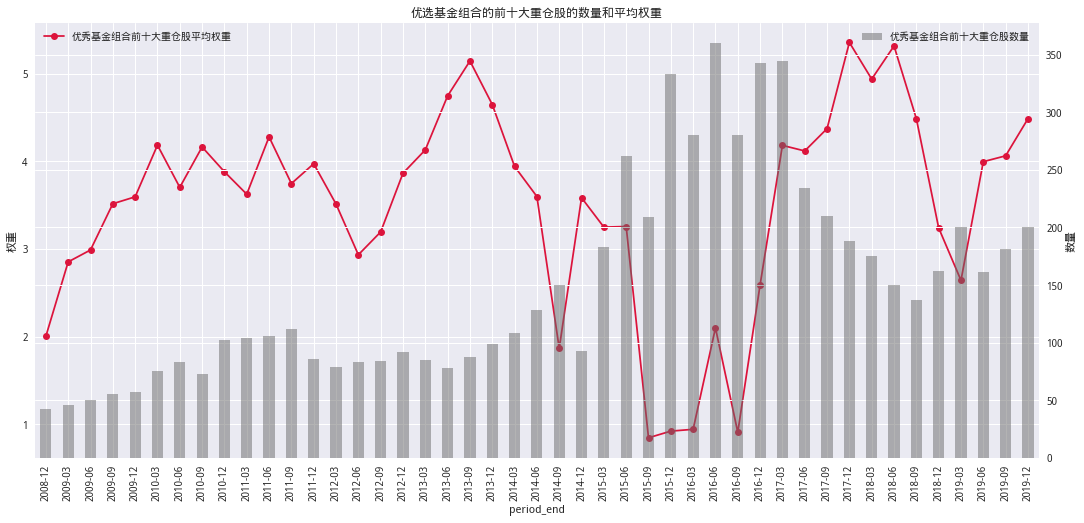

In [20]:
View_Hold_Stock(hold_df)

## 优选基金的超配股

**不同基金的持仓分散程度不同，持仓集中度高的股票，其重仓股更具代表性**。假设A，B基金均是优选基金，A基金的第一大权重股Sa占5%，B 基金的第一大权重股Sb占比达到 15%，则股票 Sb 更能代表基金B的业绩表现，更能反映基金经理的投资思路。因而，配置股票Sb 相比 配置股票 Sa 能够更好地抓住优秀基金经理带来的超额收益。因而，我们在优选基金组合的前十大重仓股中，做进一步的筛选，选出其中的超配股票。 

考虑到不同基金的股票投资比例不尽相同，我们按照**持股市值占基金总股票投资市值的比例(这里JQdata中仅有股票占净值的占比,所以我们只能用此进行分析)**对股票进行排序。在优选基金的前十大重仓股票池中，再选权重排名前 10%的股票作为优选基金 组合的超配股。这些超配股票都是基金经理精选挑选的，具有强烈信心的战略性重仓配置品种，普遍具有明朗的成长前景和较高的投资价值，可以更好地反映基金经理的投资思路。在投资组合中合理配置这些超配股票，可以更好地捕捉到来自优秀基金经理的超额收益。 

需要注意的是：如果某只股票被多只基金持有，且权重排名均在前 10%，那么计算平均权重作为该股票的基金持仓权重。下图展示了我们每季度选择出来的优选基金组合超配股的数量和平均流通市值。最近三年超配股数量在15只左右，平均流通市值显著提高，基本均在 1000 亿以上。平均持仓权重变化不大，在 11%左右。

In [21]:
def View_Overweight(hold_df:pd.DataFrame):
    
    hold_df = hold_df.copy()
    
    hold_df['period_end'] = pd.to_datetime(hold_df['period_end'])
    hold_df['period_end'] = hold_df['period_end'].dt.strftime('%Y-%m')
    
    
    df = hold_df.groupby('period_end',group_keys=False).apply(CreatOverWeightTable)
    
    df['mktcap_mean'].plot(figsize=(18, 8),
                title='优选基金组合超配股的数量和平均流通市值',
                marker='o',
                color='#DC143C')
                    
    plt.xticks(rotation=90)
    plt.ylabel('市值')
    plt.legend(['优秀基金超配股平均流通市值'],loc='upper left')
    plt.twinx()
    df['num'].plot.bar(alpha=0.5, color='#696969')
    plt.ylabel('数量')
    plt.legend(['优秀基金超配股数量'],loc='upper right')
    plt.show()
    
    
def GetOverWeightStock(df:pd.DataFrame)->list:
    '''获取超配股票列表'''
    
    symbol_mean_weight = df.groupby('symbol')['proportion'].mean()
    
    # 降序
    threshold = np.nanpercentile(symbol_mean_weight,90)
    return symbol_mean_weight[symbol_mean_weight >= threshold].index.tolist()
    
def CreatOverWeightTable(df:pd.DataFrame)->pd.DataFrame:
    
    '''构建超配股票股票信息'''
    
    target_stocks = GetOverWeightStock(df)
    
    return pd.DataFrame({'num':len(target_stocks),
                  'mktcap_mean':df.query('symbol == @target_stocks')['market_cap'].mean()},
                index=[df.name])

In [22]:
hold_df['symbol'] = hold_df['symbol'].str.replace(r'\D','')

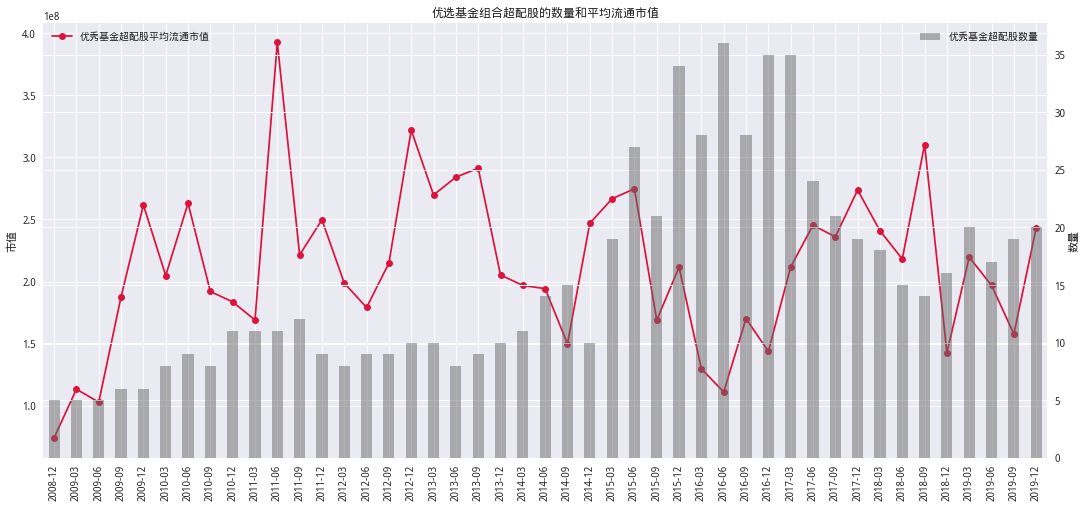

In [23]:
View_Overweight(hold_df)

下面我们统计每期的优选基金超配股是否是沪深 300 或者中证 500 成分股。可以看到，平均 来看，六成以上的超配股为沪深 300 成分股，中证 500 成分股平均来看仅占 15%。2017 年以来 属于沪深 300 成分股的超配股比例一直处于高位，在 70%左右，反映出优选基金近三年的持仓风格越来越偏向于大盘股。

In [24]:
def View_Overweight(hold_df: pd.DataFrame):

    hold_df = hold_df.copy()

    start_date, end_date = min(
        hold_df['period_end']), max(hold_df['period_end'])

    # 格式化日期标签
    hold_df['period_end'] = pd.to_datetime(hold_df['period_end'])
    hold_df['period_end'] = hold_df['period_end'].dt.strftime('%Y-%m')

    # 获取指数成分股字典
    cons_dict = QueryIndexCons('000300.XSHG', start_date, end_date)
    zz_dict = QueryIndexCons('000905.XSHG', start_date, end_date)

    cons_dict.update(zz_dict)  # 合并字典

    # 标记超配股票所属
    df = hold_df.groupby('period_end').apply(
        CreatOverWeightNum, cons_dict=cons_dict)

    # 格式化数据 以备画图
    df = df.reset_index(level=1, drop=True)
    df = df.groupby(level='period_end')['is_cons'].value_counts(normalize=True)
    df = df.to_frame('per')

    df = df.unstack(level=1)
    #df = df.swaplevel(axis=1)
    df.columns = df.columns.levels[1]

    idx = df.index  # X轴
    # Y轴数据
    p1 = df['000300.XSHG'].values
    p2 = df['000905.XSHG'].values
    p3 = df['其他'].values
    
    # df直接出图 pandas 1.1.0
    #df.plot.bar(stacked=True,
    #            figsize=(18,8),
    #            title='优选基金组合超配股在沪深300和中证500指数中的分布',
    #            color={"000300.XSHG":'Crimson',
    #                 '000905.XSHG':'CornflowerBlue',
    #                  '其他':'DimGray'})  
    
    # 绘制堆积百分比条形图
    plt.figure(figsize=(18, 8))
    plt.title('优选基金组合超配股在沪深300和中证500指数中的分布')
    plt.bar(idx, p1, width=0.4, label='HS300', color='#DC143C')
    plt.bar(idx, p2, width=0.4, bottom=p1, label='ZZ500', color='#6495ED')
    plt.bar(idx, p3, width=0.4, bottom=p1 + p2, label='OTHER', color='#696969')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()


def CreatOverWeightNum(df: pd.DataFrame, cons_dict: dict) -> pd.DataFrame:
    
    '''获取超配股并标记所属指数'''
    
    # 超配股票
    target_stocks = GetOverWeightStock(df)

    is_cons = list(map(lambda x: cons_dict.get(x, '其他'), target_stocks))

    return pd.DataFrame({'symbol': target_stocks,
                         'is_cons': is_cons},
                        )


def QueryIndexCons(index_symbol: str, start_date: str, end_date: str) -> dict:
    '''
    获取指数成分股并做标记 
    -------------
        key:cons_code,values:index_symbol
    '''

    period = pd.date_range(start_date, end_date, freq='Q')

    cons = []

    for d in period:

        cons_list = [i.split('.')[0]
                     for i in get_index_stocks(index_symbol, date=d)]
        cons += set(cons_list + cons)

    cons = dict(zip(cons, [index_symbol] * len(cons)))

    return cons


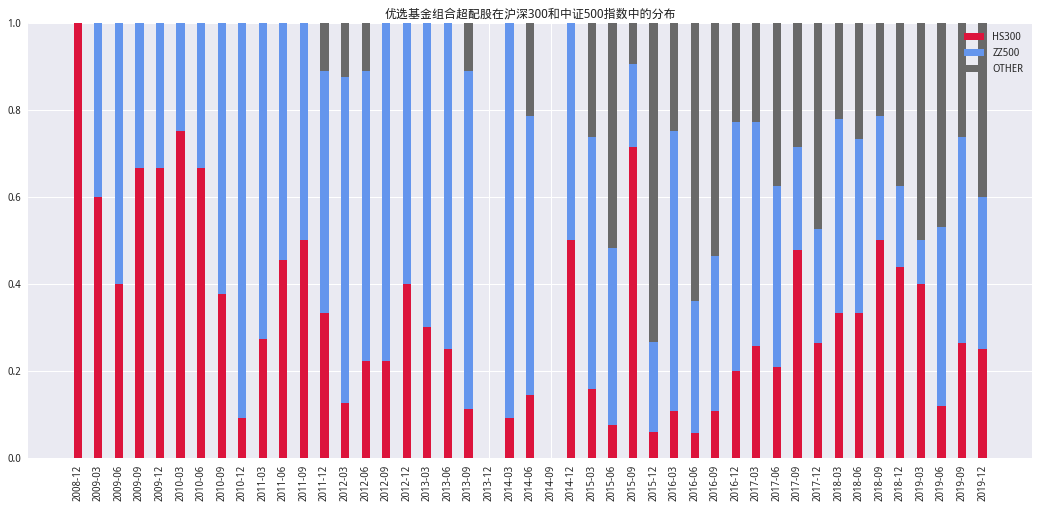

In [25]:
View_Overweight(hold_df)

# 构造优选基金的超配组合

## 组合构建方法

每季度，我们将优选基金组合的超配股，按照等权的方法构成组合。考察该 组合在下个季度的收益情况。由于基金重仓股信息要等到每个季度结束之日起十五个工作日内才 能获得，因而此处我们在计算收益时将时间窗口均滞后 15 个交易日，避免引入未来信息。（例如
2019/06/30 调仓时，考察的是 2019/07/19 — 2019/10/21 这 60 天中的组合收益情况）

In [26]:
def OffsetDate(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]
    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')


def VieAlgorithmNav(hold_df: pd.DataFrame) -> pd.DataFrame:
    '''简单回测'''
    #df_list = {}
    df_list = []

    for rptdate, df in hold_df.groupby('period_end'):

        stocks = GetOverWeightStock(df)

        # 格式化股票代码
        # if len(code) >= 6 过滤港股 前十大中有港股数据
        stocks = [normalize_code(code) for code in stocks if len(code) >= 6]

        start_date = OffsetDate(rptdate.strftime('%Y-%m-%d'), 15)
        end_date = OffsetDate(rptdate.strftime('%Y-%m-%d'), 75)

        # 模拟季度调仓 季度持仓
        #close_df = get_price(stocks,end_date=start_date,count=1,fields='close',panel=False)
        #next_close = get_price(stocks,end_date=end_date,count=1,fields='close',panel=False)
        #next_ret_ser = next_close.set_index('code')['close'] / close_df.set_index('code')['close'] - 1
        #df_list[rptdate] = next_ret_ser

        # 模拟季度调仓 日度持仓
        ## 模拟逻辑：换仓时清仓后买入
        close = get_price(stocks, start_date, end_date,
                          fields='close', panel=False)
        ret_df = pd.pivot_table(close, index='time',
                                columns='code', values='close').pct_change()
        ret_ser = ret_df.mean(axis=1)

        df_list.append(ret_ser)

    df = pd.concat(df_list).dropna()
    #df.index.names = ['date','code']

    # 通过调仓确定基准周期
    begin = min(df.index)
    end = max(df.index)

    # 获取基准
    benchmark = get_price(['000300.XSHG', '000905.XSHG'],
                          begin, end, fields='close', panel=False)
    benchmark = pd.pivot_table(
        benchmark, index='time', columns='code', values='close')
    benchmark.columns = ['HS300', 'ZZ500']
    # 计算净值
    AlgorithmNav = benchmark.iloc[:, :] / benchmark.iloc[0, :]
    #AlgorithmNav = AlgorithmNav.resample('Q').last()
    AlgorithmNav = AlgorithmNav.reindex(df.index)
    AlgorithmNav['基金重仓股等权组合'] = (1+df.dropna()).cumprod()

    return AlgorithmNav


# 计算组合收益率分析:年化收益率、收益波动率、夏普比率、最大回撤
def strategy_performance(nav_df: pd.DataFrame, benchmark_col: str) -> pd.DataFrame:

    # part1:根据回测净值计算相关指标的数据准备（日度数据）
    # nav_next=nav_df.shift(1)
    # return_df=(nav_df-nav_next)/nav_next  #计算净值变化率，即为日收益率,包含组合与基准
    return_df = nav_df.pct_change().dropna()  # 在计算净值变化率时，首日得到的是缺失值，需将其删除

    analyze = pd.DataFrame()  # 用于存储计算的指标

    # part2:计算年化收益率
    cumulative = np.exp(np.log1p(return_df).cumsum())
    # cum_return=np.exp(np.log1p(return_df).cumsum())-1   #计算整个回测期内的复利收益率
    cum_return = cumulative-1
    annual_return_df = (1+cum_return)**(252/len(return_df))-1  # 计算年化收益率
    analyze['annual_return'] = annual_return_df.iloc[-1]  # 将年化收益率的Series赋值给数据框

    # part3:计算收益波动率（以年为基准）
    # return中的收益率为日收益率，所以计算波动率转化为年时，需要乘上np.sqrt(252)
    analyze['return_volatility'] = return_df.std()*np.sqrt(252)

    # part4:计算夏普比率
    risk_free = 0
    return_risk_adj = return_df-risk_free
    analyze['sharpe_ratio'] = return_risk_adj.mean() / \
        np.std(return_risk_adj, ddof=1)

    # prat5:计算最大回撤
    # cumulative=np.exp(np.log1p(return_df).cumsum())*100  #计算累计收益率
    cumulative = cumulative * 100
    max_return = cumulative.cummax()  # 计算累计收益率的在各个时间段的最大值
    analyze['max_drawdown'] = cumulative.sub(max_return).div(
        max_return).min()  # 最大回撤一般小于0，越小，说明离1越远，各时间点与最大收益的差距越大

    # part6:计算相对指标
    analyze['relative_return'] = analyze['annual_return'] - \
        analyze.loc[benchmark_col, 'annual_return']  # 计算相对年化波动率
    analyze['relative_volatility'] = analyze['return_volatility'] - \
        analyze.loc[benchmark_col, 'return_volatility']  # 计算相对波动
    analyze['relative_drawdown'] = analyze['max_drawdown'] - \
        analyze.loc[benchmark_col, 'max_drawdown']  # 计算相对最大回撤

    # part6:计算信息比率
    return_diff = return_df.sub(
        return_df[benchmark_col], axis=0).std()*np.sqrt(252)  # 计算策略与基准日收益差值的年化标准差
    analyze['info_ratio'] = analyze['relative_return'].div(return_diff)

    return analyze.T

# 构建每年的收益表现函数


def get_return_year(nav: pd.DataFrame, benchmark_col: str) -> pd.DataFrame:

    result_dic = {}  # 用于存储每年计算的各项指标
    for y, df in nav.groupby(pd.Grouper(level='time', freq='Y')):

        result = strategy_performance(df, benchmark_col)

        result_dic[y.strftime('%Y')] = result.iloc[:, -1]

    result_df = pd.DataFrame(result_dic)

    return result_df.T


## 收益情况

从超额收益来看，优选基金超配组合相对HS300,ZZ500指数均能取得不错的超额收益。从 2008-2019年，相对于沪深 300、中证 500 指数均可以取得超过 10% 的年均超额收益。最近三年组合表现尤为突出，相对于全市场等权组合可以取得年均 30%的超额 收益，相对中证全指的超额收益为 23%，相对沪深 300 和中证 500 指数的超额收益分别为 16%和27%。 相比于优选基金前十大重仓股组合，收益实现了翻倍提升。

,基金重仓股等权组合,HS300
annual_return,0.230707,0.058897
return_volatility,0.285303,0.245818
sharpe_ratio,0.054872,0.022451
max_drawdown,-0.528165,-0.466961
relative_return,0.171810,0.000000
relative_volatility,0.039485,0.000000
relative_drawdown,-0.061205,0.000000
info_ratio,0.928064,NaN


,annual_return,return_volatility,sharpe_ratio,max_drawdown,relative_return,relative_volatility,relative_drawdown,info_ratio
2009,1.170221,0.335550,0.156226,-0.196102,0.307596,0.007275,0.056539,1.923579
2010,0.324883,0.239973,0.081421,-0.123665,0.445396,-0.013174,0.171334,2.815603
2011,-0.426252,0.225019,-0.148283,-0.451509,-0.148492,0.006886,-0.135082,-1.032105
2012,0.432759,0.251667,0.097940,-0.152696,0.330109,0.044279,0.071358,2.034115
2013,0.528172,0.281163,0.103923,-0.132133,0.609186,0.057941,0.089458,2.553970
2014,0.319603,0.261594,0.075062,-0.199351,-0.237405,0.069561,-0.102156,-0.933525
2015,0.492781,0.431422,0.072179,-0.515066,0.466858,0.034976,-0.080220,1.674258
2016,-0.123213,0.315326,-0.016273,-0.264211,-0.074752,0.101947,-0.070401,-0.380649
2017,0.229052,0.149947,0.091394,-0.090439,0.010664,0.046331,-0.029764,0.100619
2018,-0.183117,0.286215,-0.035537,-0.333420,0.092463,0.066335,-0.014646,0.594667


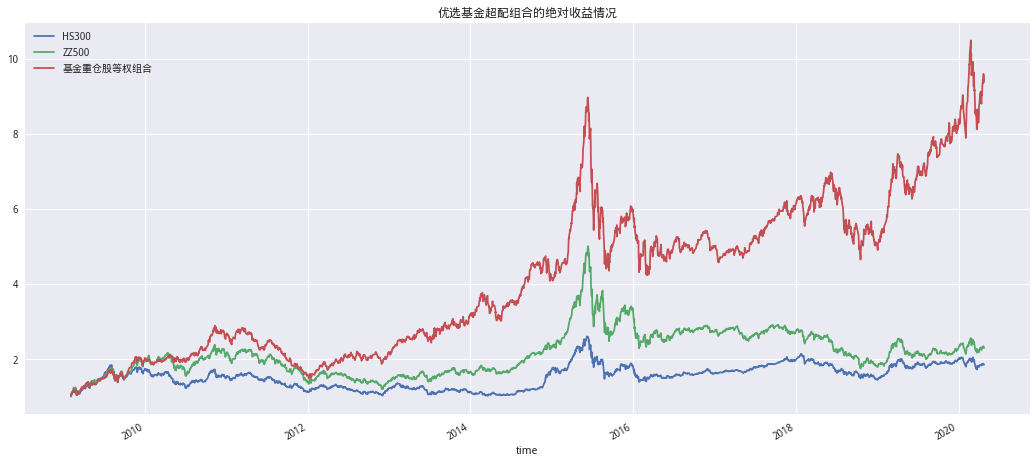

In [27]:
df = VieAlgorithmNav(hold_df)

plt.rcParams['font.family']='serif'

df.plot(figsize=(18,8),
                   title='优选基金超配组合的绝对收益情况')

# 此时的基准为HS300
print_table(strategy_performance(df[['基金重仓股等权组合','HS300']],'HS300'))

print_table(get_return_year(df,'HS300'))

In [28]:
def View_Industry(hold_fund:pd.DataFrame):
    
    industry = QueryIndustry(hold_df)
    group_industry = industry.groupby('industry')['RET'].mean()
    
    plt.rcParams['font.family']='serif'
    
    
    fig = plt.figure(figsize=(12,10))
    fig.add_subplot(1,2,1)
    group_industry.sort_index().plot.barh(color='#DC143C',title='优选基金超配组合的行业配置情况')
    plt.legend(['历史平均收益'])
    plt.axvline(0,color='black')
    
    fig.add_subplot(1,2,2)
    industry['industry'].value_counts(normalize=True).sort_index().plot.barh(title='行业配置占比',color='#6495ED')
    plt.legend(['历史行业配置'])
    

def QueryIndustry(hold_df:pd.DataFrame)->pd.DataFrame:
    
    hold_fund = hold_df.copy()
    hold_fund['symbol'] = hold_fund['symbol'].replace(r'\D','',regex=True)
    df_list = []

    for rptdate, df in hold_df.groupby('period_end'):

        stocks = GetOverWeightStock(df)

        # 格式化股票代码
        # if len(code) >= 6 过滤港股 前十大中有港股数据
        stocks = [normalize_code(code) for code in stocks if len(code) >= 6]
        
        ## 获取行业
        ind = get_industry(security=stocks, date=rptdate)

        ind = {
            x: v.get('sw_l1').get('industry_name', np.nan)
            for x in ind.keys() for v in ind.values() if 'sw_l1' in v.keys()
        }
    
        start_date = OffsetDate(rptdate.strftime('%Y-%m-%d'), 15)
        
        end_date = OffsetDate(rptdate.strftime('%Y-%m-%d'), 75)
        
        # 模拟季度调仓 日度持仓
        close = get_price(stocks, start_date, end_date,
                          fields='close', panel=False)
        
        ret_df = pd.pivot_table(close, index='time',
                                columns='code', values='close').pct_change()
        
        ret_df.columns = list(map(lambda x: ind.get(x, '其他'), ret_df.columns))
        
        ret_ser = ret_df.stack()
        

        df_list.append(ret_ser)

    ret_ser = pd.concat(df_list)
    ret_ser.index.names = ['date','industry']
    ret_ser.name = 'RET'
    return ret_ser.reset_index()

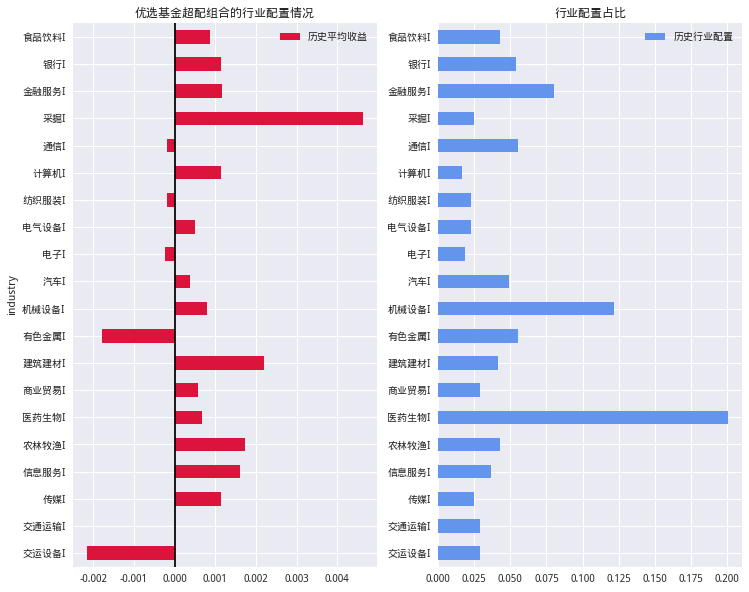

In [29]:
View_Industry(hold_df)